<a href="https://colab.research.google.com/github/denisecammarota/d2ai-notes/blob/main/ch4_d2ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F

# Softmax regression with MNIST and minibatch GD

## Loading and preparing data

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # mean and std for grayscale
])

In [ ]:
train_dataset = datasets.FashionMNIST(
    root=torch.hub.get_dir(),  # uses PyTorch's hub cache directory
    train=True,
    download=True,
    transform=transform
)


test_dataset = datasets.FashionMNIST(
    root=torch.hub.get_dir(),
    train=False,
    download=True,
    transform=transform
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
len(train_dataset), len(test_dataset) # 60.000 data for training, 10.000 data for testing

(60000, 10000)

In [ ]:
len(train_loader), len(test_loader) # 938 train dataset, 157 test dataset

(938, 157)

In [ ]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
] # labels

## Visualizing an example

In [ ]:
image, label = train_dataset[0] # this is a tuple, so we deconstruct it this way

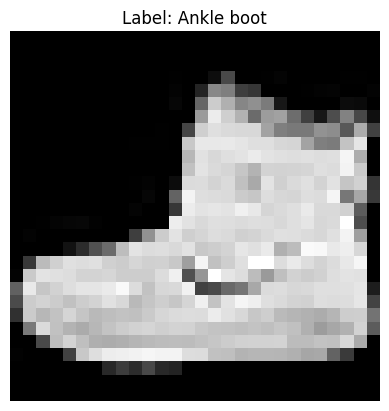

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {class_names[label]}")
plt.axis("off")
plt.show()

##  Definining the model

In [ ]:
class SoftmaxRegression(nn.Module):

  def __init__(self, n_classes):
      super().__init__()
      self.model = nn.Sequential(nn.Flatten(),
                                  nn.LazyLinear(out_features = n_classes))
      # the loss already calculates the softmax before computing, so no softmax here

  def forward(self, x):
    return self.model(x)

## Training/fitting

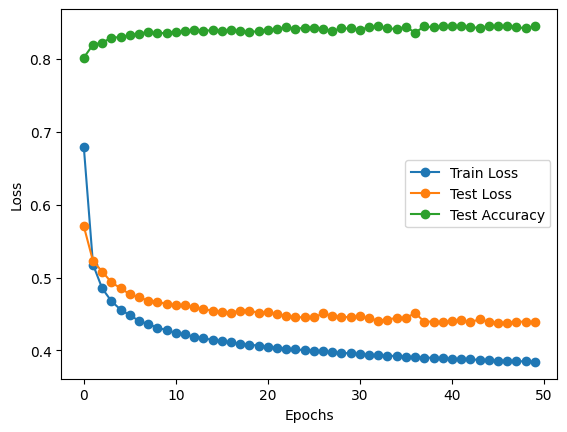

In [ ]:
model = SoftmaxRegression(n_classes = 10)
criterion = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = optim.SGD(model.parameters(), lr = 0.01)

n_epochs = 50
train_loss = []
test_loss = []
test_accuracy = []

for epoch in range(n_epochs):
  train_aux = 0
  test_aux = 0
  test_aux_acc = 0

  # training mode for model
  model.train()
  for batch_X, batch_y in train_loader:
    optimizer.zero_grad()
    output = model(batch_X)
    loss = criterion(output, batch_y)
    loss.backward()
    optimizer.step()
    train_aux += loss.item() * len(batch_X) # * 64 (batch_size, except for the last batch maybe)
  train_loss.append(train_aux/len(train_dataset)) # / number of training dataset

  # test mode for model
  model.eval()
  with torch.no_grad():
    for batch_X, batch_y in test_loader:
      output = model(batch_X)
      loss = criterion(output, batch_y)
      predicted_label = output.argmax(dim = 1)
      test_aux += loss.item() * len(batch_X) # * 64 (batch_size, except for the last batch maybe)
      test_aux_acc +=  (predicted_label == batch_y).sum().item()
    test_loss.append(test_aux/len(test_dataset)) # / number of testing dataset
    test_accuracy.append(test_aux_acc/len(test_dataset))


plt.plot(range(n_epochs), train_loss, '-o', label = 'Train Loss')
plt.plot(range(n_epochs), test_loss, '-o', label = 'Test Loss')
plt.plot(range(n_epochs), test_accuracy, '-o', label = 'Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Plotting an example

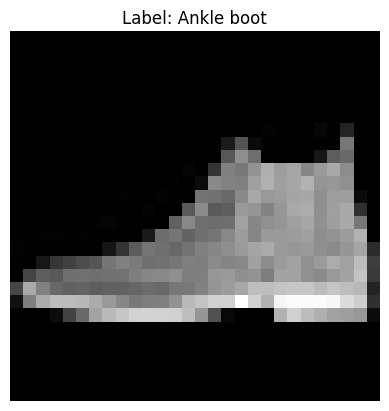

In [ ]:
# Ground truth
image, label = test_dataset[0] # this is a tuple, so we deconstruct it this way
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {class_names[label]}")
plt.axis("off")
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
  probabilities = F.softmax(model(image), dim = 1)
  predicted_class = np.argmax(probabilities)

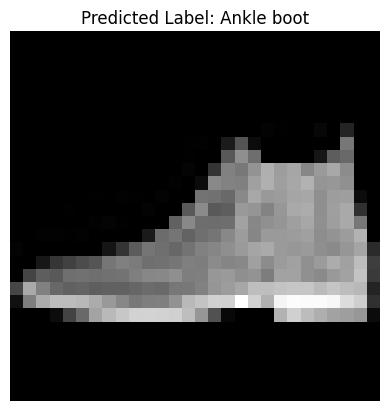

In [ ]:
# Predicted truth
image, label = test_dataset[0] # this is a tuple, so we deconstruct it this way
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Predicted Label: {class_names[predicted_class]}")
plt.axis("off")
plt.show()